# TD N°2 SVM

## Consigne

1) Charger le dataset bostong_housing
   1) Disponible dans le folder 04_interpretable_ml/td/data/
   
2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest
   1) Tester d'ajouter des features log, quadratique, ...

3)Créer un modèle baseline linéaire et random forest

4) Interpréter le modèle linéaire

5) Tuner votre random forest

6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

6) Réaliser une explicabilité par individu
   1) En utilisant la méthode ICE (PDP individuelle)
   2) LIME (Model local pour expliquer une prédiction)
   3) SHAP watterfall plot (Contribution marginale de chaque variable dans la prédiction)

7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

## Description des données
Le Boston Housing Dataset est un ensemble de données couramment utilisé en apprentissage automatique et en statistique pour étudier les relations entre diverses caractéristiques socio-économiques et immobilières dans la ville de Boston.  
Il contient des informations sur des propriétés résidentielles et leur environnement, et est souvent utilisé pour prédire la valeur des maisons, un problème classique de régression.

**Variable dispo**: 
- CRIM : taux de criminalité par habitant par ville
- ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : proportion de terrains commerciaux non commerciaux par ville
- CHAS : variable binaire indiquant la proximité de la rivière Charles (= 1 si la zone délimitée par la ville touche la rivière ; 0 sinon)
- NOX : concentration des oxydes d'azote (en parties par 10 millions)
- RM : nombre moyen de pièces par logement
- AGE : proportion des unités occupées par leur propriétaire et construites avant 1940
- DIS : distances pondérées vers cinq centres d'emploi de Boston
- RAD : indice d'accessibilité aux autoroutes radiales
- TAX : taux d'imposition foncière par valeur totale pour chaque tranche de 10 000 dollars
- PTRATIO : ratio élèves-enseignants par ville
- LSTAT : pourcentage de la population de statut socio-économique inférieur
- MEDV : valeur médiane des maisons occupées par leur propriétaire (en milliers de dollars) - **variable cible**

# 1) Charger le dataset bostong_housing

In [ ]:
import requests
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nbformat
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

from lime.lime_tabular import LimeTabularExplainer
import shap
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import lime
import lime.lime_tabular

/Users/noa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/noa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Depuis github
url = "https://raw.githubusercontent.com/Roulitoo/cours_iae/master/04_INTERPRETABLE_ML/td/data/boston_housing.csv" 
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

## Nettoyage des données

In [5]:
df.head()

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2


In [6]:
# Format du dataset
df.shape

(506, 14)

506 lignes, 14 colonnes
On remarque qu'il y a une colonne ID, qui ne nous intéresse pas (notre BDD est déjà indexée nativement via pandas)

In [7]:
df = df.drop(columns=['Unnamed: 0'])

### Présence de NA

In [8]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

Visiblement, aucune valeur manquante n'est présente.

In [9]:
# Vérifions s'il existe des doublons
df.duplicated().sum()

np.int64(0)

Aucun doublons non plus

In [10]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object

Les variables **CHAS** et **RAD** sont des variables catégorielles, il convient donc de les transformer:

In [11]:
df['CHAS'] = df['CHAS'].astype('category')
df['RAD'] = df['RAD'].astype('category')

In [12]:
df.dtypes

CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
LSTAT       float64
MEDV        float64
dtype: object

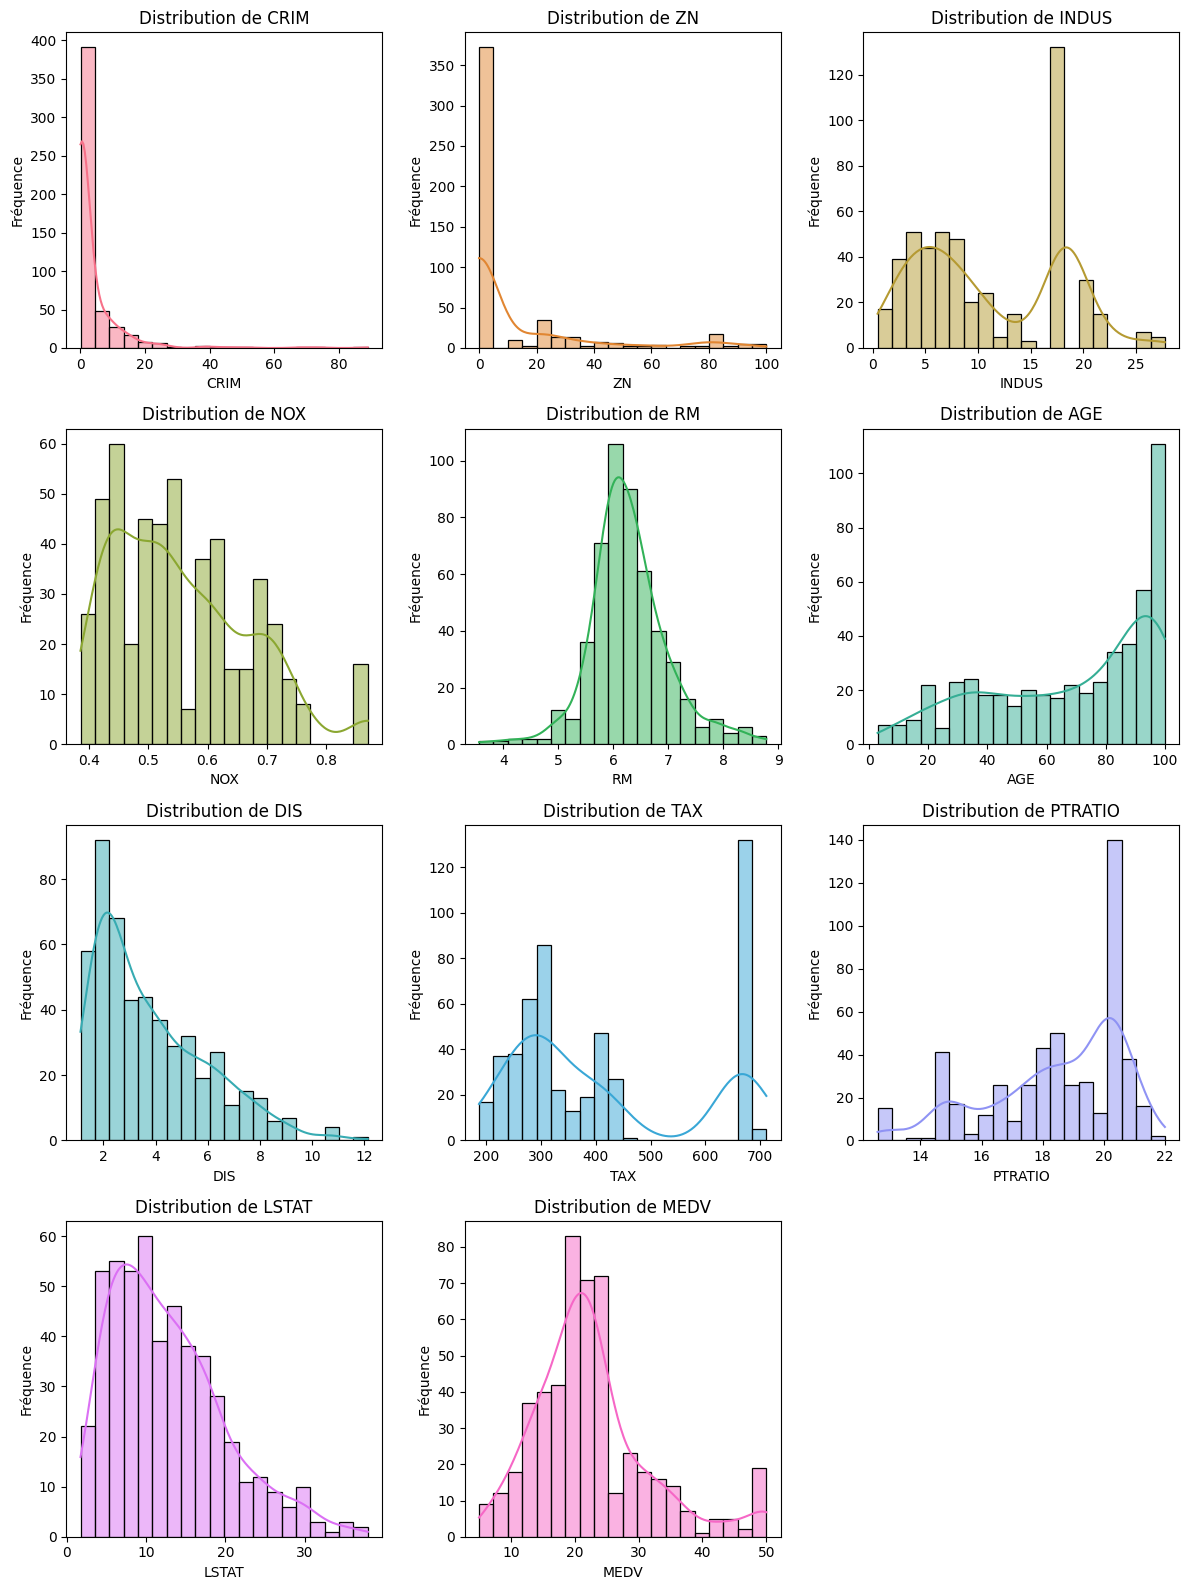

In [13]:
# Distribution des variables quantitatives

# Sélection des colonnes numériques
quantitative_columns = df.select_dtypes(include=['float64']).columns

# Paramètres pour les sous-graphiques
num_vars = len(quantitative_columns)
cols = 3  # Nombre de colonnes de sous-graphiques
rows = (num_vars + cols - 1) // cols  # Calcul du nombre de lignes
colors = sns.color_palette("husl", num_vars)  # Palette de couleurs

# Création des sous-graphiques
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()  # Aplatir les axes pour les itérer facilement

for i, column in enumerate(quantitative_columns):
    sns.histplot(df[column], kde=True, bins=20, color=colors[i], ax=axes[i])
    axes[i].set_title(f'Distribution de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Fréquence')

# Supprimer les axes inutilisés si le nombre de variables est impair
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster les espaces entre les graphiques
plt.tight_layout()
plt.show()

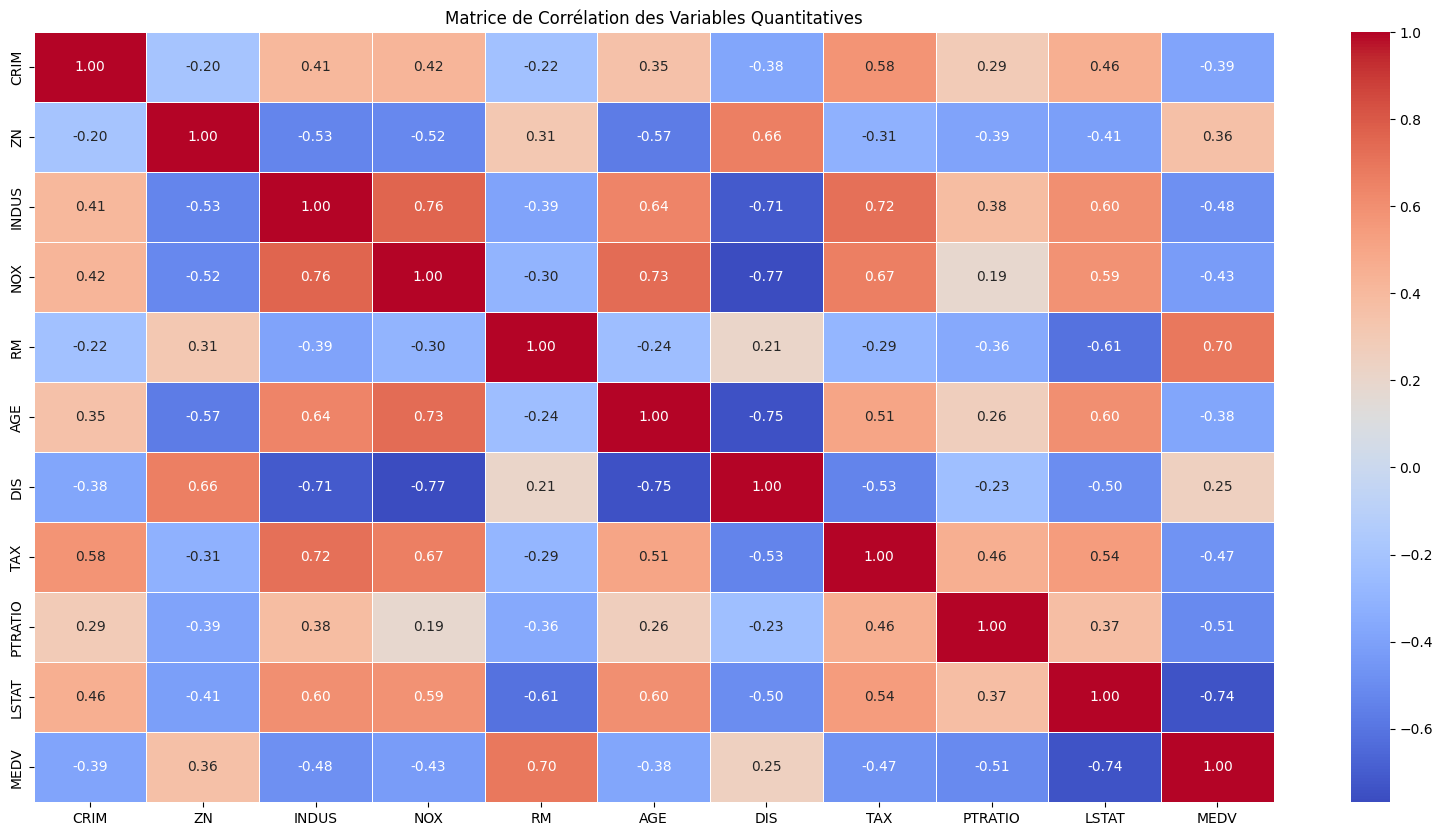

In [14]:
#Matrice de corrélations - lien linéaire entre 2 variables

# Sélectionner uniquement les variables quantitatives
quantitative_columns = df.select_dtypes(include=['float64', 'int64'])

# Calculer la matrice de corrélation uniquement sur les variables quantitatives
correlation_matrix = quantitative_columns.corr()

# Afficher la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de Corrélation des Variables Quantitatives')
plt.show()

Quelques corrélations importantes:

**Corrélations Positives**
- **INDUS & NOX** : 0.76  
- **INDUS & TAX** : 0.72  
- **NOX & AGE** : 0.73  
- **RM & MEDV** : 0.70  
- **AGE & NOX** : 0.73  
- **TAX & INDUS** : 0.72  
- **DIS & ZN** : 0.66  

**Corrélations Négatives**  
- **DIS & NOX** : -0.77  
- **DIS & AGE** : -0.75  
- **LSTAT & MEDV** : -0.74  
- **DIS & INDUS** : -0.71  
- **RM & LSTAT** : -0.61  
- **RM & PTRATIO** : -0.61  


# 2)Nettoyer votre jeu de données pour créer une régression linéaire et un random forest

Penser à :

- Vérifier comment encoder vos variables qualitatives pour la modélisation 
- Analyser les distributions
- Analyser les outliers 
- Analyser les corrélations

>Tester d'ajouter des features log, quadratique, ...

In [15]:
# Sélectionner les variables numériques pour la standardisation
numerical_features = df.select_dtypes(include=[np.number]).columns
non_numerical_features = df.select_dtypes(exclude=[np.number]).columns

# Standardisation des variables
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)
# résumé des données
df_standardized.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,LSTAT,MEDV
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000,5.060000e+02,5.060000e+02,5.060000e+02
mean,-1.123388e-16,7.898820e-17,2.106352e-16,-1.965929e-16,-1.088282e-16,-1.474446e-16,-8.425408e-17,0.000000,-4.212704e-16,-3.089316e-16,-5.195668e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.197819e-01,-4.877224e-01,-1.557842e+00,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-1.313990,-2.707379e+00,-1.531127e+00,-1.908226e+00
25%,-4.109696e-01,-4.877224e-01,-8.676906e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-0.767576,-4.880391e-01,-7.994200e-01,-5.994557e-01
50%,-3.906665e-01,-4.877224e-01,-2.110985e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-0.464673,2.748590e-01,-1.812536e-01,-1.450593e-01
75%,7.396560e-03,4.877224e-02,1.015999e+00,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.530926,8.065758e-01,6.030188e-01,2.685231e-01
max,9.933931e+00,3.804234e+00,2.422565e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.798194,1.638828e+00,3.548771e+00,2.989460e+00


In [16]:
df_FULL = pd.concat([df[non_numerical_features], df_standardized], axis=1)
df_FULL.shape

(506, 13)

In [17]:
df_FULL.head() # Notre BDD avec données quanti standardisées et quali


,CHAS,RAD,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,LSTAT,MEDV
0,0,1,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.666608,-1.459000,-1.075562,0.159686
1,0,2,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.987329,-0.303094,-0.492439,-0.101524
2,0,2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.987329,-0.303094,-1.208727,1.324247
3,0,3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-1.106115,0.113032,-1.361517,1.182758
4,0,3,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-1.106115,0.113032,-1.026501,1.487503


### Outliers

In [18]:
import nbformat

# Analyse des outliers

# Créer un DataFrame pour Plotly (ajouter une colonne pour les noms des variables)
df_standardized_melted = df_standardized.melt(var_name='Variables', value_name='Standardized Values')

# Créer un boxplot interactif avec Plotly sans légende
fig = px.box(df_standardized_melted, x='Variables', y='Standardized Values', color='Variables', 
             title='Boxplots des Variables Standardisées', 
             labels={'Standardized Values': 'Valeurs Standardisées'}, 
             color_discrete_sequence=px.colors.qualitative.Set1)

# Supprimer la légende
fig.update_layout(showlegend=False)

# Afficher le graphique
fig.show()

On voit qu'il existe de nombreux outliers, notamment dans les variables **CRIM**, **RM**, et quelques unes dans **DIS** et **LSTAT**.

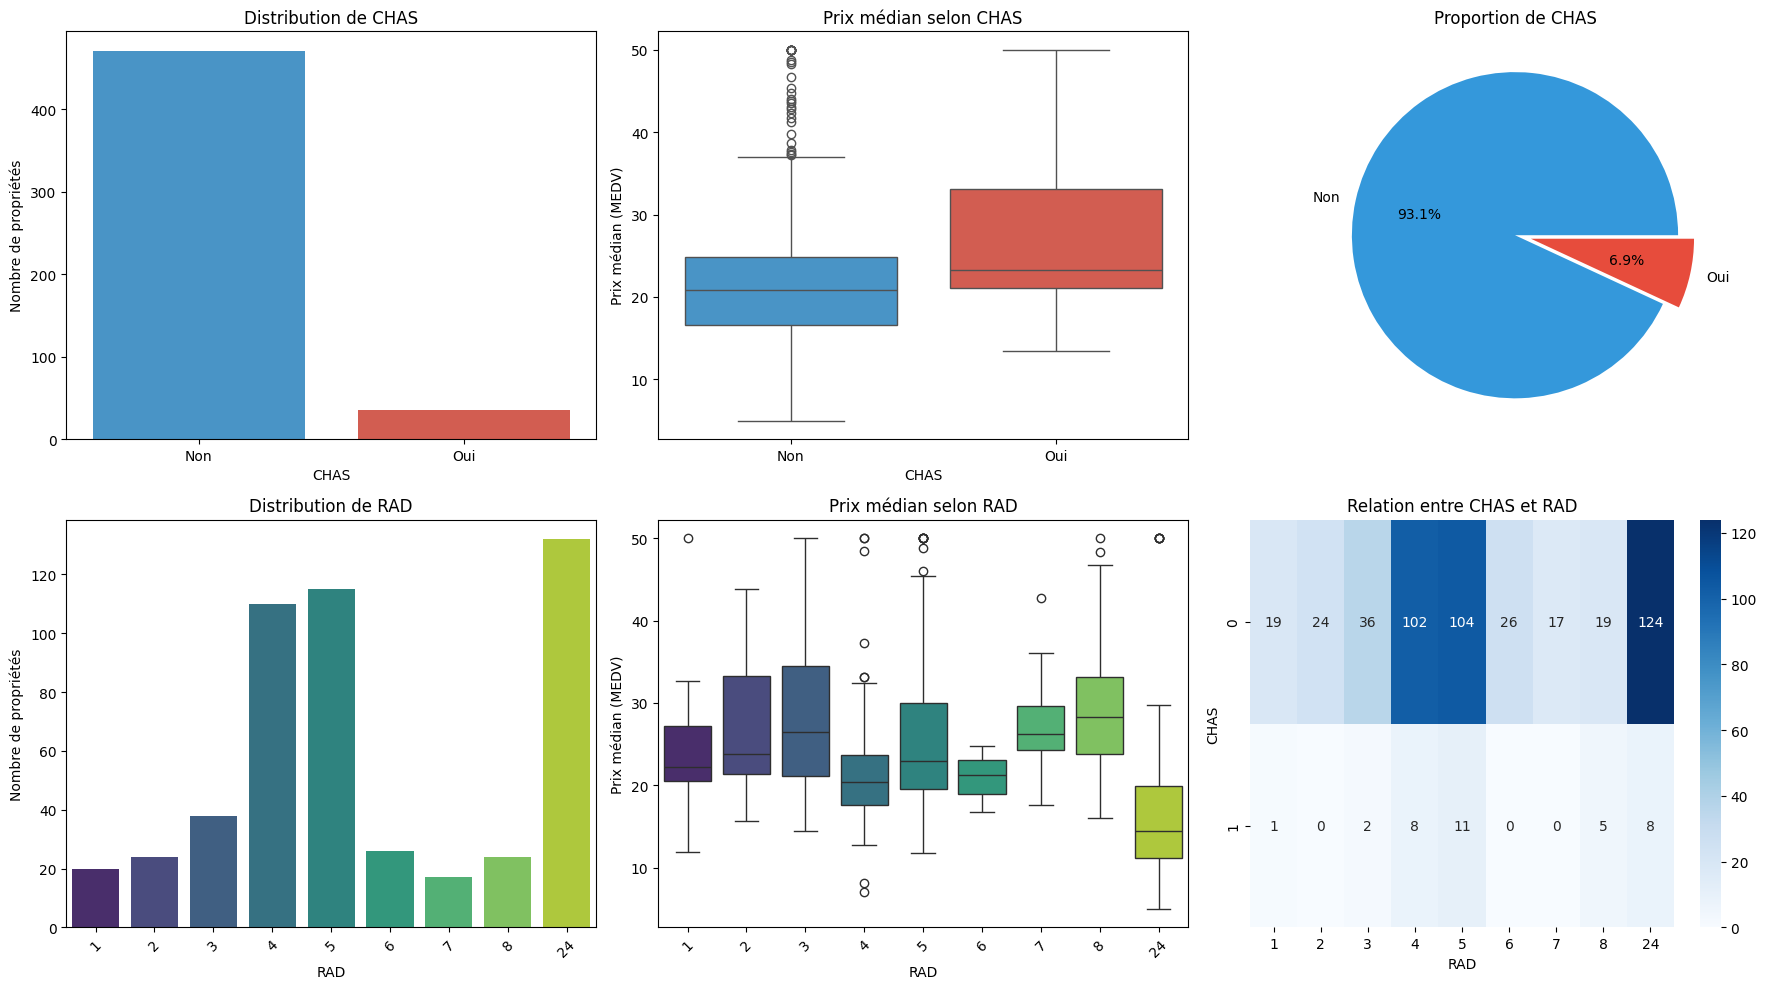

In [19]:
# Créer une figure avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Première ligne: CHAS
# Distribution de CHAS
sns.countplot(x='CHAS', data=df, ax=axes[0][0], palette=['#3498db', '#e74c3c'])
axes[0][0].set_title('Distribution de CHAS')
axes[0][0].set_xticklabels(['Non', 'Oui'])
axes[0][0].set_ylabel('Nombre de propriétés')

# Boxplot MEDV par CHAS
sns.boxplot(x='CHAS', y='MEDV', data=df, ax=axes[0][1], palette=['#3498db', '#e74c3c'])
axes[0][1].set_title('Prix médian selon CHAS')
axes[0][1].set_xticklabels(['Non', 'Oui'])
axes[0][1].set_ylabel('Prix médian (MEDV)')

# Camembert pour CHAS
axes[0][2].pie(df['CHAS'].value_counts(), labels=['Non', 'Oui'], autopct='%1.1f%%', 
               colors=['#3498db', '#e74c3c'], explode=[0, 0.1])
axes[0][2].set_title('Proportion de CHAS')

# Deuxième ligne: RAD et relation CHAS-RAD
# Distribution de RAD
sns.countplot(x='RAD', data=df, ax=axes[1][0], palette='viridis')
axes[1][0].set_title('Distribution de RAD')
axes[1][0].set_ylabel('Nombre de propriétés')
axes[1][0].tick_params(axis='x', rotation=45)

# Boxplot MEDV par RAD
sns.boxplot(x='RAD', y='MEDV', data=df, ax=axes[1][1], palette='viridis')
axes[1][1].set_title('Prix médian selon RAD')
axes[1][1].set_ylabel('Prix médian (MEDV)')
axes[1][1].tick_params(axis='x', rotation=45)

# Heatmap de CHAS vs RAD
heatmap_data = pd.crosstab(df['CHAS'], df['RAD'])
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d', ax=axes[1][2])
axes[1][2].set_title('Relation entre CHAS et RAD')
axes[1][2].set_ylabel('CHAS')

plt.tight_layout()
plt.show()

- La majorité des propriétés (93,1%) ne sont pas situées près de la rivière Charles.
- Seules 6,9% des propriétés ont la variable `CHAS = 1`.
- Les propriétés proches de la rivière (`CHAS = 1`) ont un prix médian plus élevé en moyenne que celles qui en sont éloignées (`CHAS = 0`).
- Cela suggère que la proximité de la rivière Charles pourrait être un facteur influençant positivement la valeur des biens immobiliers.
- Les valeurs de `RAD` sont concentrées principalement autour de quelques catégories spécifiques, notamment `RAD = 4` et `RAD = 24`, qui regroupent le plus grand nombre de propriétés.
- Les prix médians varient en fonction de `RAD`, mais sans tendance évidente. Cependant, certaines valeurs de `RAD` semblent associées à des prix plus faibles, notamment `RAD = 24`.
- La majorité des propriétés ayant `CHAS = 0` sont réparties sur plusieurs niveaux de `RAD`, en particulier `RAD = 4` et `RAD = 24`.
- Les propriétés proches de la rivière (`CHAS = 1`) sont plus rares, mais leur distribution sur `RAD` est plus dispersée.
- On observe que même pour `CHAS = 1`, `RAD = 4` et `RAD = 24` restent des valeurs fréquentes.

## Encodage

In [20]:
df = df_FULL # on repasse en df pour plus de simplicité
df.RAD.unique()

[1, 2, 3, 5, 4, 8, 6, 7, 24]
Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 8, 24]

In [21]:
label_encoder = LabelEncoder()
df['RAD'] = label_encoder.fit_transform(df['RAD'])
df.RAD.unique()


array([0, 1, 2, 4, 3, 7, 5, 6, 8])

Cet encodage simplifie le processus de modélisation

## Ajout de features

In [22]:
# Création de nouvelles features
# Log transformations pour les variables à distribution asymétrique
df['CRIM_log'] = np.log1p(df['CRIM'])
df['ZN_log'] = np.log1p(df['ZN'])

# Transformations quadratiques
df['RM_sq'] = df['RM'] ** 2
df['DIS_sq'] = df['DIS'] ** 2
df['LSTAT_sq'] = df['LSTAT'] ** 2

# Interactions
df['RM_LSTAT'] = df['RM'] * df['LSTAT']
df['NOX_INDUS'] = df['NOX'] * df['INDUS']

In [23]:
# Somme des NA
df.isna().sum()

CHAS         0
RAD          0
CRIM         0
ZN           0
INDUS        0
NOX          0
RM           0
AGE          0
DIS          0
TAX          0
PTRATIO      0
LSTAT        0
MEDV         0
CRIM_log     0
ZN_log       0
RM_sq        0
DIS_sq       0
LSTAT_sq     0
RM_LSTAT     0
NOX_INDUS    0
dtype: int64

# 3) Créeer deux modèles baseline: linéaire & random forest

## Diviser les données

In [24]:
# X représente toutes nos variables sauf notre variable cible (Y: MEDV)
X = df.drop(columns=['MEDV'])
y = df['MEDV']  #Variable cible

# On sépare en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Afficher les dimensions des ensembles
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Dimensions de X_train: (404, 19)
Dimensions de X_test: (102, 19)
Dimensions de y_train: (404,)
Dimensions de y_test: (102,)


## Linéaire

In [25]:
linear_model = LinearRegression()

#Entraîner le modèle sur les données d'entraînement
linear_model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_linear = linear_model.predict(X_test)

#Calculer les performances du modèle
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Régression Linéaire")
print(f"Mean Squared Error (MSE): {mse_linear}")
print(f"R-squared (R2): {r2_linear}")

Régression Linéaire
Mean Squared Error (MSE): 0.16662866455928196
R-squared (R2): 0.8081822960880609


## Random Forest

In [26]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")

Random Forest
Mean Squared Error (MSE): 0.08891677925112448
R-squared (R2): 0.8976417864218827


La régression linéaire présente un MSE de 0,166, associée à un R² de 0,80. Ces valeurs témoignent d'une capacité prédictive modérée, expliquant approximativement 80% de la variance des données observées. 

En revanche, l'algorithme de forêt aléatoire démontre des performances supérieures avec une MSE de 0,088. Le coefficient R² atteint 0,897 pour ce modèle, indiquant que près de 89,7% de la variabilité est expliquée par les prédictions. 

Cette supériorité du modèle de forêt aléatoire suggère peut-être la présence de relations non-linéaires dans les données que le modèle de régression linéaire ne parvient pas à capturer efficacement.

# 4) Interpréter le modèle linéaire

In [27]:
#Afficher les p-values des coefficients
X_with_intercept = sm.add_constant(X_train)  #Ajouter une constante (intercept) à X
model = sm.OLS(y_train, X_with_intercept).fit()  #Créer un modèle MCO
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     90.16
Date:                Fri, 07 Mar 2025   Prob (F-statistic):          1.32e-128
Time:                        15:31:33   Log-Likelihood:                -236.11
No. Observations:                 404   AIC:                             512.2
Df Residuals:                     384   BIC:                             592.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4484      0.127     -3.535      0.0

Le modèle explique environ 82% de la variation des prix des maisons à Boston, ce qui indique une bonne performance prédictive. Les caractéristiques du logement et du quartier jouent des rôles déterminants dans la valeur immobilière.

Le nombre de pièces (RM) influence positivement le prix des maisons, avec un effet qui s'accentue pour les grands logements comme le montre le terme quadratique significatif. À l'inverse, le pourcentage de population défavorisée (LSTAT) exerce l'impact négatif le plus important sur les prix, confirmant l'influence du statut socio-économique du voisinage.

La proximité de la rivière Charles augmente significativement la valeur des propriétés, tandis que la pollution atmosphérique (NOX), l'éloignement des centres d'emploi (DIS), le taux de criminalité et un ratio élèves-enseignants élevé la réduisent.

Les termes quadratiques significatifs pour la distance et le statut socio-économique révèlent que leurs effets ne sont pas strictement linéaires. En revanche, les transformations logarithmiques n'apportent pas d'amélioration significative au modèle.

Ces résultats confirment que la valeur immobilière à Boston est déterminée par une combinaison de facteurs structurels (taille du logement), environnementaux (pollution, proximité de l'eau) et socio-économiques (composition du quartier, éducation, criminalité).

# 5) Tuner votre random forest

In [28]:
# Définition de la grille de paramètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialisation du modèle de base
rf = RandomForestRegressor(random_state=42)

# Configuration du Grid Search avec validation croisée à 5 plis
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Exécution du Grid Search
print("Démarrage du Grid Search...")
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés:")
print(grid_search.best_params_)

Démarrage du Grid Search...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Meilleurs paramètres trouvés:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
# Récupération du meilleur modèle
best_rf_model = grid_search.best_estimator_

# Entraînement avec les meilleurs paramètres (déjà fait par GridSearchCV, mais pour être explicite)
print("\nEntraînement du modèle avec les meilleurs paramètres...")
best_rf_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_best_rf = best_rf_model.predict(X_test)

# Calcul des métriques d'évaluation
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

# Affichage des résultats
print("\nRandom Forest (paramètres optimisés)")
print(f"Mean Squared Error (MSE): {mse_best_rf:.6f}")
print(f"R-squared (R2): {r2_best_rf:.6f}")


Entraînement du modèle avec les meilleurs paramètres...



Random Forest (paramètres optimisés)
Mean Squared Error (MSE): 0.114804
R-squared (R2): 0.867841


Le modèle *"optimisé"* est moins performant que le modèle brut, ce qui peut être signe d'over-fitting avec le jeu d'entrainement.

### Contributions des variables

Importance des variables:
      Feature  Importance
6          RM    0.221706
11      LSTAT    0.198874
14      RM_sq    0.095062
17   RM_LSTAT    0.068057
5         NOX    0.052746
4       INDUS    0.051060
16   LSTAT_sq    0.048312
12   CRIM_log    0.045772
2        CRIM    0.041720
10    PTRATIO    0.039376
8         DIS    0.035574
9         TAX    0.028802
7         AGE    0.017598
18  NOX_INDUS    0.017146
15     DIS_sq    0.017005
1         RAD    0.009772
3          ZN    0.004948
0        CHAS    0.003614
13     ZN_log    0.002856


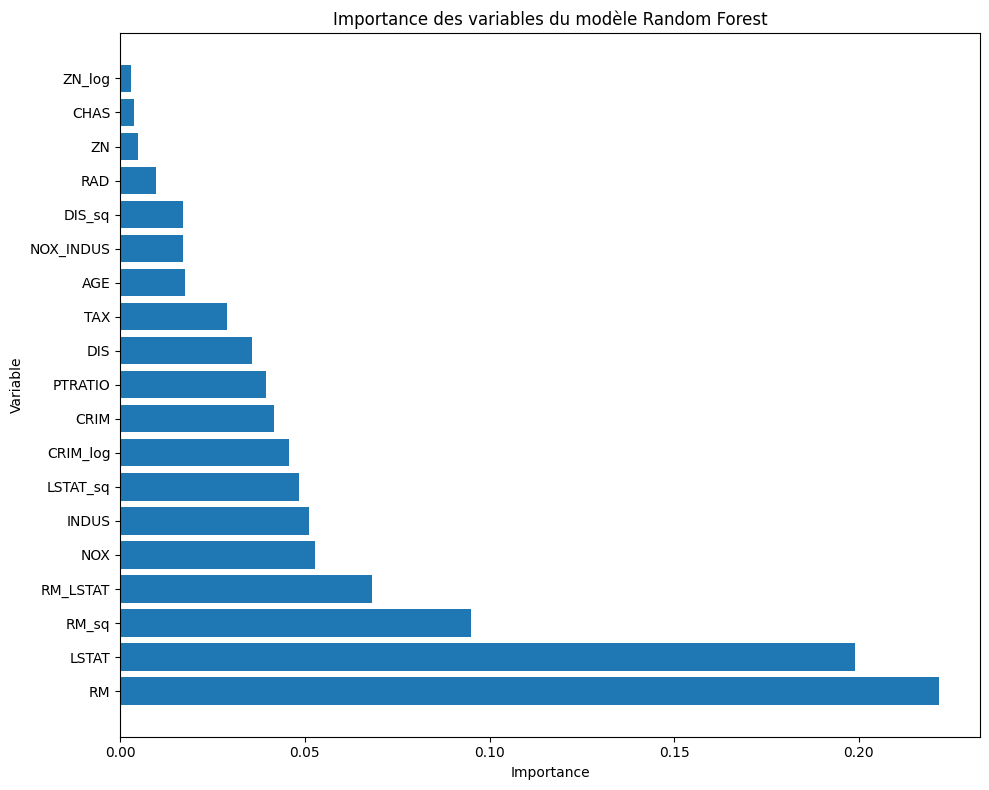

In [30]:
# Récupérer l'importance des features
importances = best_rf_model.feature_importances_

# Créer un DataFrame pour faciliter le tri
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Afficher les valeurs numériques
print("Importance des variables:")
print(feature_importance_df)

# Créer le graphique
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Importance des variables du modèle Random Forest')
plt.tight_layout()
plt.show()

Le modèle Random Forest optimisé présente de bonnes performances prédictives avec un R² de 0,868, indiquant que 86,8% de la variance des prix médians des logements (MEDV) est expliquée par le modèle. L'erreur quadratique moyenne (MSE) de 0,115 est relativement faible, confirmant la bonne précision des prédictions.
Importance des variables

L'analyse révèle une hiérarchie claire des déterminants du prix immobilier à Boston :

- Caractéristiques structurelles du logement : Le nombre moyen de pièces (RM) est le facteur le plus influent (22,2%), suivi de sa transformation quadratique (RM_sq, 9,5%), suggérant une relation non-linéaire entre la taille du logement et son prix.
- Facteurs socio-économiques : Le pourcentage de population à statut socio-économique inférieur (LSTAT, 19,9%) est le deuxième prédicteur le plus important, avec sa transformation quadratique (LSTAT_sq, 4,8%) également significative.
- Interactions entre variables : L'interaction RM_LSTAT (6,8%) montre que l'effet du nombre de pièces varie selon le statut socio-économique du quartier.
- Facteurs environnementaux : La concentration d'oxydes d'azote (NOX, 5,3%) et la proportion de terrains industriels (INDUS, 5,1%) ont un impact modéré, reflétant l'influence de la qualité environnementale.
-Variables de moindre importance : La proximité de la rivière Charles (CHAS, 0,4%) et la proportion de grands terrains résidentiels (ZN, 0,5%) ont un impact marginal sur les prix immobiliers.

La présence significative de termes d'interaction et de transformations quadratiques justifie l'utilisation d'un modèle non-linéaire comme Random Forest pour capturer la complexité des relations entre les variables.

In [31]:
# Fonction pour créer une figure avec un nombre dynamique de sous-graphiques
def create_subplot_figure(n_plots, n_cols=3, figsize_per_plot=(5, 4)):
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig_width = figsize_per_plot[0] * n_cols
    fig_height = figsize_per_plot[1] * n_rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    if n_rows * n_cols > n_plots:  # Si on a plus de cases que de plots
        for i in range(n_plots, n_rows * n_cols):
            # Déterminer les indices de ligne et de colonne
            row_idx = i // n_cols
            col_idx = i % n_cols
            
            # Si axes est 2D, utiliser les indices, sinon axes est un tableau 1D
            if n_rows > 1:
                fig.delaxes(axes[row_idx, col_idx])
            else:
                fig.delaxes(axes[col_idx])
                
    return fig, axes

# A. Permutation Feature Importance
def plot_permutation_importance(model, X, y, feature_names, n_repeats=10):
    """Calcule et affiche l'importance des variables par permutation."""
    result = permutation_importance(
        model, X, y, n_repeats=n_repeats, random_state=42, n_jobs=-1
    )
    perm_importance_df = pd.DataFrame(
        {'Feature': feature_names,
         'Importance': result.importances_mean,
         'Std': result.importances_std}
    ).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='viridis')
    plt.title('Permutation Feature Importance', fontsize=15)
    plt.xlabel('Importance (diminution de la performance)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return perm_importance_df

In [32]:
# Noms de mes variables
feature_names = df.columns
feature_names

Index(['CHAS', 'RAD', 'CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'LSTAT', 'MEDV', 'CRIM_log', 'ZN_log', 'RM_sq', 'DIS_sq',
       'LSTAT_sq', 'RM_LSTAT', 'NOX_INDUS'],
      dtype='object')

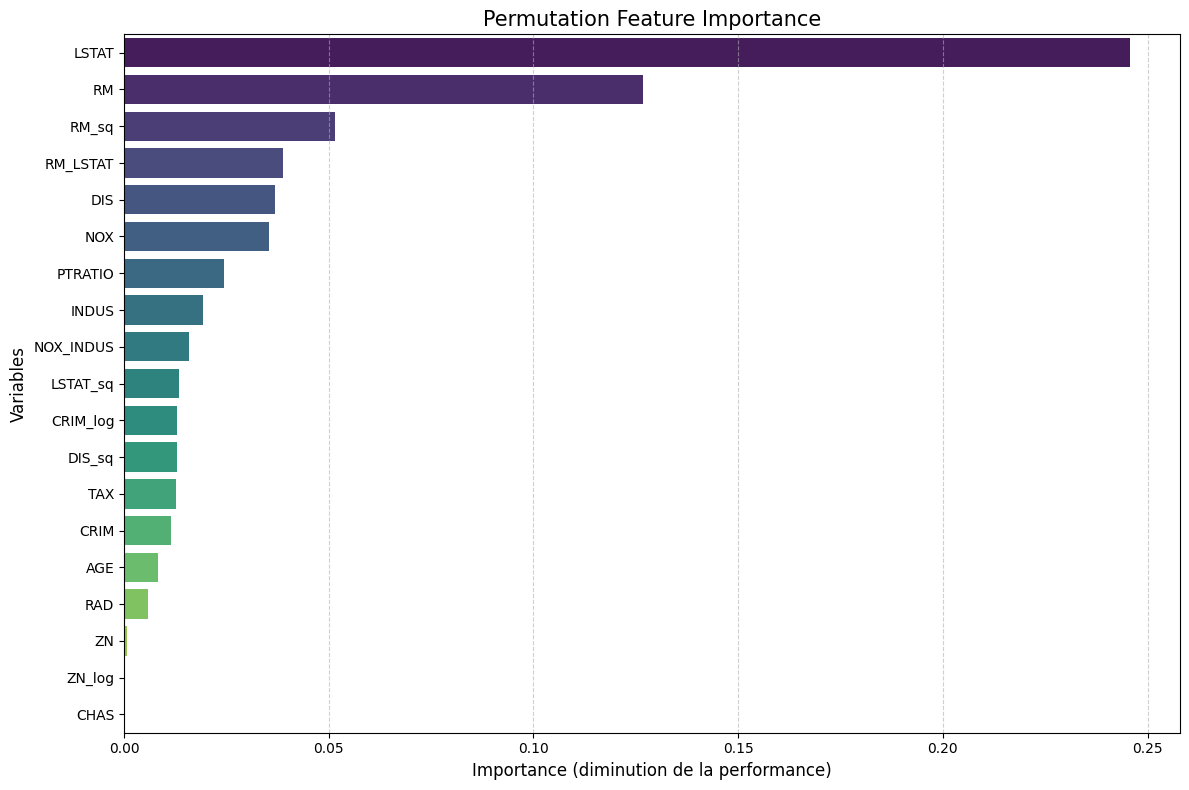

In [33]:
perm_importance = plot_permutation_importance(best_rf_model, X_test, y_test, X.columns)

La variable LSTAT, représentant le pourcentage de population de statut socio-économique inférieur, se démarque considérablement comme le prédicteur le plus influent avec une valeur d'importance avoisinant 0,24. Cette prédominance suggère que les caractéristiques socio-économiques des quartiers constituent un facteur déterminant dans l'estimation des prix immobiliers à Boston.

La variable RM, correspondant au nombre moyen de pièces par logement, occupe la deuxième position avec une importance d'environ 0,13, confirmant l'hypothèse selon laquelle les caractéristiques structurelles des habitations jouent un rôle significatif dans la détermination de leur valeur. Il est intéressant de noter que RM_sq, la version quadratique de RM, se positionne en troisième place, ce qui indique une relation non-linéaire entre le nombre de pièces et le prix des logements.

Les variables RM_LSTAT, DIS et NOX présentent des importances modérées, entre 0,03 et 0,05, suggérant que les interactions entre le statut socio-économique et la taille des logements, la distance aux centres d'emploi, ainsi que la concentration d'oxyde d'azote contribuent de façon non négligeable à la performance du modèle.

Les variables ayant trait à la criminalité (CRIM et CRIM_log), à la taxation (TAX) et à l'âge des bâtiments (AGE) montrent une influence plus limitée mais toujours perceptible. En revanche, les facteurs liés au zonage (ZN et ZN_log) et au ratio de superficie commerciale (CHAS) présentent une importance quasi nulle, indiquant que ces caractéristiques urbaines n'affectent que marginalement les prix immobiliers dans le contexte du modèle analysé.

Cette distribution d'importance met en évidence l'influence prépondérante des facteurs socio-économiques et structurels dans la détermination des prix immobiliers à Boston, tandis que les aspects réglementaires et commerciaux semblent jouer un rôle secondaire dans le pouvoir prédictif du modèle.

In [ ]:
# B. Partial Dependence Plots (PDP) pour les variables les plus importantes
def plot_pdp(model, X, feature_names, top_n=6):
    """Crée des graphiques de dépendance partielle pour les n variables les plus importantes."""
    # Sélectionner les features les plus importantes selon l'importance du modèle
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        top_features = feature_importance.head(top_n)['Feature'].values
    else:
        # Si le modèle n'a pas d'attribut feature_importances_, utiliser les 6 premières
        top_features = feature_names[:top_n]
    
    # Créer les PDP
    fig, ax = plt.subplots(figsize=(15, 10))
    display = PartialDependenceDisplay.from_estimator(
        model, 
        X, 
        features=top_features, 
        kind='average', 
        grid_resolution=50, 
        random_state=42,
        ax=ax
    )
    plt.suptitle('Partial Dependence Plots')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


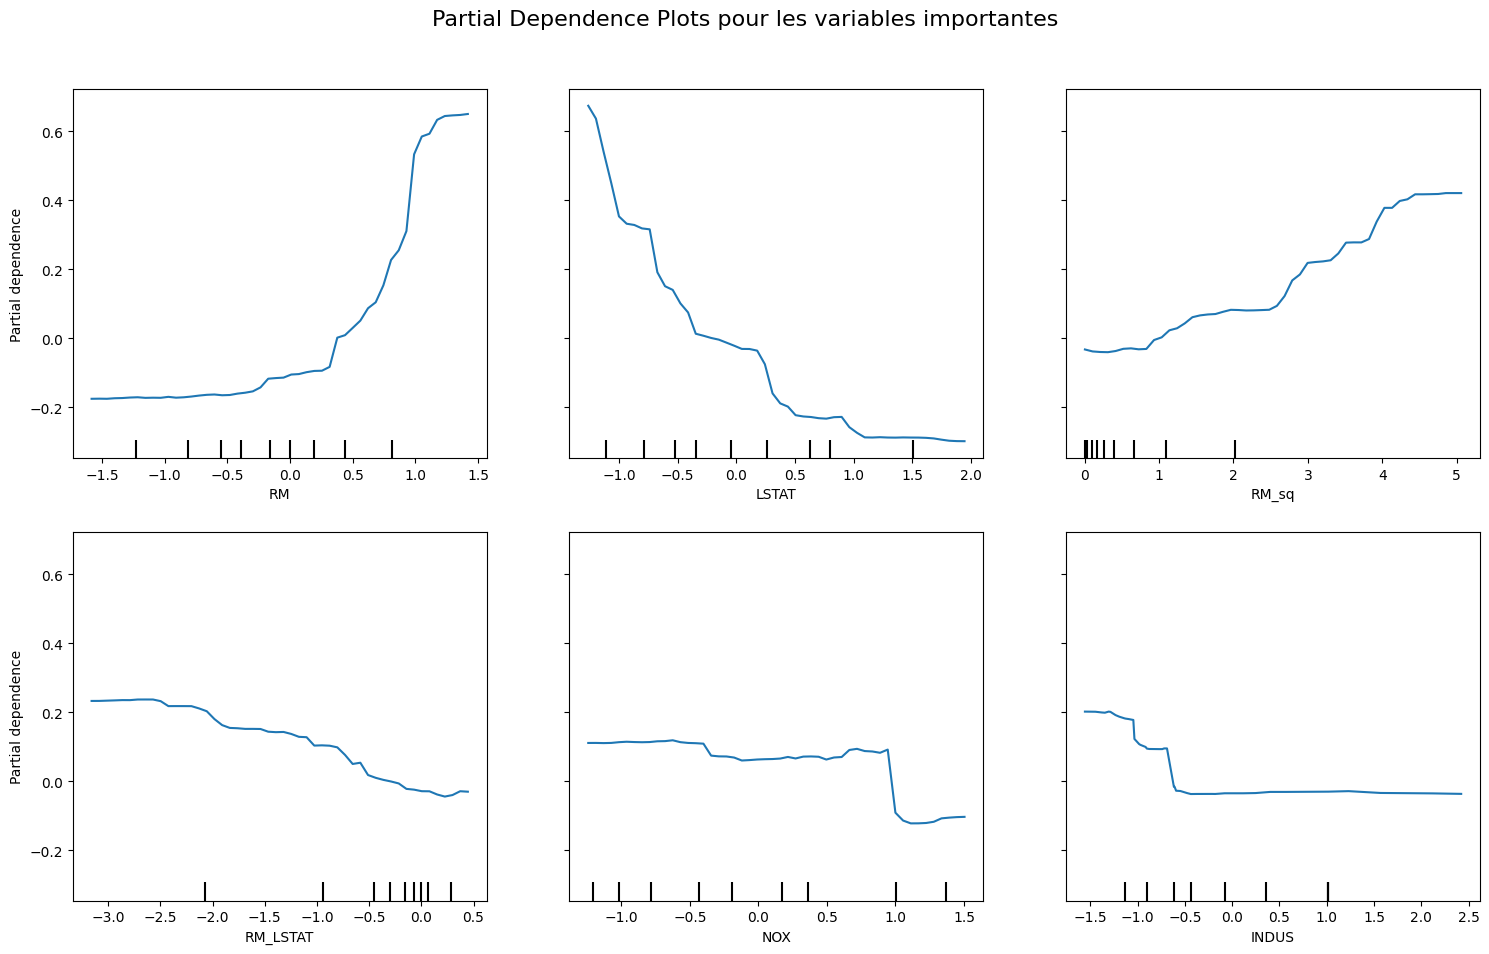

In [38]:
plot_pdp(best_rf_model, X_test, X.columns)

Ce graphique représente les *Partial Dependence Plots* (PDP) des six variables les plus importantes dans notre modèle de prédiction des prix immobiliers à Boston. Ces courbes illustrent l'effet marginal de chaque variable sur la prédiction du modèle, en maintenant les autres constantes.

On observe que **le nombre moyen de pièces par logement (RM)** a un effet fortement positif et non linéaire : la courbe reste stable pour les valeurs faibles puis augmente significativement à partir de 0,5, suggérant que cette variable est un facteur clé dans la valorisation des propriétés. À l'inverse, **le pourcentage de la population à faible statut socio-économique (LSTAT)** présente un effet négatif marqué et constant, ce qui confirme que les quartiers avec une population plus modeste sont associés à des valeurs immobilières plus faibles.

Le **terme quadratique du nombre de pièces (RM_sq)** montre une relation positive quasi linéaire, renforçant l'importance de la taille du logement. La variable d'interaction **RM_LSTAT** présente une tendance négative, indiquant que l'effet positif du nombre de pièces diminue dans les quartiers défavorisés.

Concernant **la pollution de l'air (NOX)**, la courbe reste relativement stable jusqu'à une valeur critique, puis chute brusquement, suggérant un effet seuil au-delà duquel la pollution impacte fortement les prix. Enfin, pour **la proportion de terrains non commerciaux (INDUS)**, on observe une forte baisse initiale suivie d'une stabilisation, indiquant un impact plus prononcé à faibles concentrations industrielles.

Globalement, RM, LSTAT et leurs dérivées apparaissent comme les variables les plus déterminantes dans l'explication des prix immobiliers à Boston.

In [42]:
top_features = feature_importance_df.head(5)['Feature'].tolist()
top_features

['RM', 'LSTAT', 'RM_sq', 'RM_LSTAT', 'NOX']

# 7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

## ICE

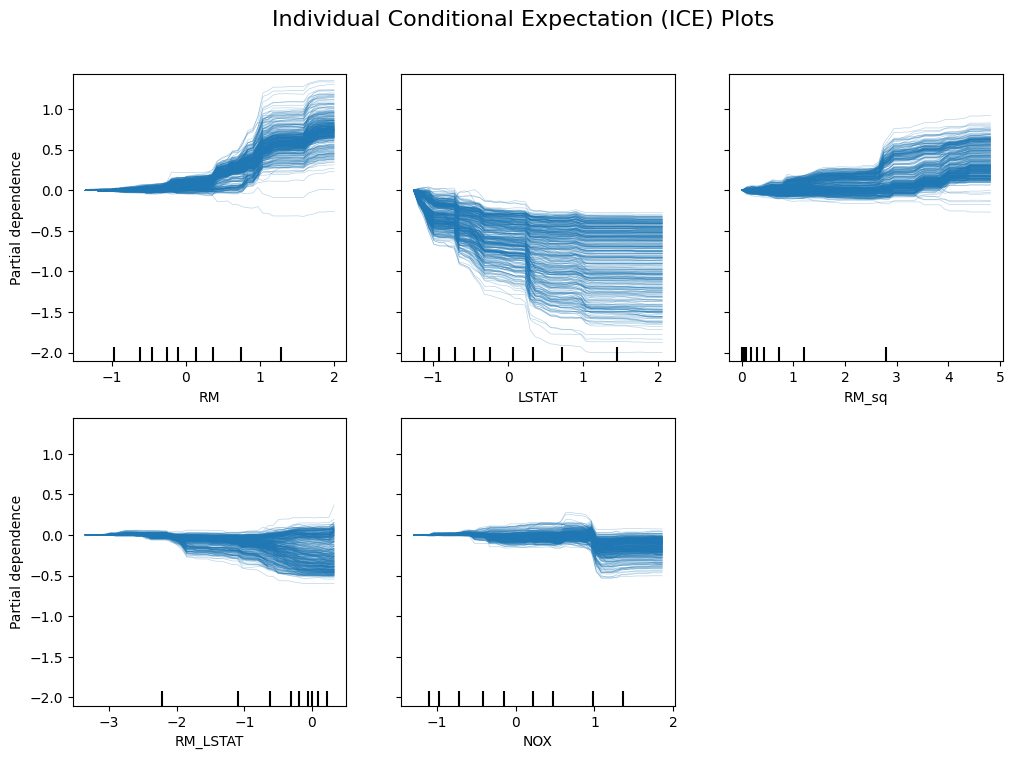

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

display = PartialDependenceDisplay.from_estimator(
    best_rf_model,
    X=X_train,
    features=top_features,
    kind="individual",  # Spécifier ICE
    grid_resolution=50,
    ax=ax,
)

plt.suptitle("Individual Conditional Expectation (ICE) Plots", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

Les graphiques d'*Individual Conditional Expectation (ICE)* présentés ici offrent une perspective plus détaillée que les PDP en illustrant comment chaque variable influence individuellement les prédictions du modèle pour le Boston Housing Dataset.

L'analyse des courbes ICE pour RM révèle une tendance positive générale, mais avec une notable dispersion au-delà de la valeur 0,5, suggérant que l'impact du nombre de pièces n'est pas uniforme pour tous les logements. Cette hétérogénéité est particulièrement visible pour les valeurs élevées où certaines observations montrent des effets beaucoup plus prononcés que d'autres.

Pour LSTAT, les courbes individuelles confirment l'effet négatif global mais dévoilent une variabilité croissante à mesure que le pourcentage de population défavorisée augmente. Cette dispersion indique que l'impact du statut socio-économique diffère significativement selon d'autres caractéristiques des quartiers.

Le graphique de RM_sq présente un profil similaire à celui de RM mais avec une dispersion encore plus marquée, tandis que RM_LSTAT montre des courbes descendantes avec une variabilité qui s'accentue vers les valeurs moins négatives. Pour NOX, on observe un comportement relativement cohérent jusqu'à environ 0,7, puis une divergence des courbes avec une tendance négative dominante.

Ces variations individuelles démontrent que, bien que les PDP capturent correctement les tendances moyennes, ils ne reflètent pas la complexité des interactions entre variables ni les effets non linéaires qui varient selon le contexte spécifique de chaque observation.

## LIME

In [ ]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode="regression"
)

# On choisit un individu dans notre BDD
i = 29  # Exemple pour l'individu 29 (en référence au plus beau département français, le finistère)
sample = X_test.iloc[i].values
model_prediction = best_rf_model.predict(sample.reshape(1, -1))

explanation = explainer.explain_instance(
    data_row=sample,
    predict_fn=best_rf_model.predict
)

explanation.show_in_notebook(show_table=True)

Ce graphique présente une analyse LIME (Local Interpretable Model-agnostic Explanations) qui décrypte les contributions individuelles des variables à la prédiction pour une observation spécifique dans le Boston Housing Dataset. 

Pour cette instance particulière (l'individu 29), le modèle prédit une valeur de 2,39 (représentée sur une échelle allant de -0,92 à 2,39). L'explication révèle que la variable RM (nombre moyen de pièces) avec une valeur supérieure à 0,50 est le facteur le plus influent, contribuant positivement à hauteur de 0,54 à la prédiction. Cette forte contribution s'explique par la valeur élevée de RM (2,49) pour cette observation, comme indiqué dans le tableau de droite.

Le second contributeur majeur est LSTAT (pourcentage de population défavorisée) avec une valeur inférieure ou égale à -0,82, ayant un impact positif de 0,49. Cette influence positive s'explique par la valeur négative de LSTAT (-1,37) qui, dans le contexte de son effet généralement négatif sur les prix immobiliers, améliore la prédiction lorsqu'elle est faible.

Les variables RM_sq (>0,95) et RM_LSTAT (≤-0,83) contribuent respectivement à hauteur de 0,22 et 0,14, confirmant l'importance des termes dérivés de RM et LSTAT. D'autres facteurs comme PTRATIO, INDUS, NOX et TAX ont des contributions positives plus modestes, toutes inférieures à 0,10.

À l'inverse, les variables CHAS (≤0,00) et NOX_INDUS (>1,14) apportent une légère contribution négative de -0,05 et -0,04 respectivement, reflétant leur impact mineur mais défavorable pour cette observation spécifique.

## SHAP VALUES

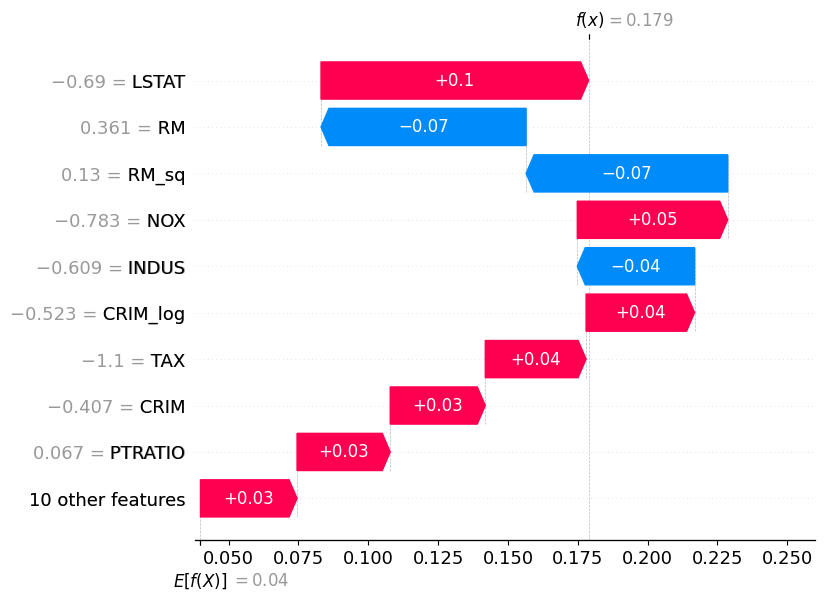

In [ ]:
explainer = shap.TreeExplainer(best_rf)

#Calculer les shap values sur un échantillon 0:100
shap_values = explainer(X_train.iloc[0:100])

shap.initjs()

# On plot le Waterfall Plot pour l'individu 29
shap.waterfall_plot(shap_values[77])

Ce *waterfall plot* issu d'une analyse SHAP permet de visualiser la contribution de chaque variable explicative à la prédiction d'une instance donnée. L'axe des \( Y \) présente les différentes variables du modèle, triées par ordre d'importance en fonction de leur impact sur la prédiction. À côté de chaque variable figure la valeur spécifique qu’elle prend pour cette instance. L'axe des \( X \), quant à lui, représente les valeurs de Shapley, c'est-à-dire la contribution individuelle de chaque variable à la prédiction finale de notre modèle RF.

La valeur de référence \( E[f(X)] = 0.04 \) correspond à la moyenne des prédictions du modèle sur l’ensemble des données d’entraînement. À partir de cette valeur initiale, chaque variable vient modifier la prédiction en l’augmentant (barres rouges) ou en la diminuant (barres bleues). Finalement, on aboutit à la prédiction finale de l’instance analysée, soit \( f(x) = 0.179 \).

Dans ce cas précis, la variable ayant le plus fort impact est **LSTAT** (proportion de la population à faible statut socio-économique), qui contribue à une hausse significative de la prédiction (+0.1). À l’inverse, **RM** (nombre moyen de pièces par logement) et **RM_sq** (sa transformation quadratique) exercent un effet négatif (-0.07 chacun), réduisant ainsi la valeur prédite. D'autres variables, comme **NOX** (concentration en oxydes d'azote), **INDUS** (proportion de terrains industriels) et **CRIM_log** (logarithme du taux de criminalité), influencent la prédiction dans une moindre mesure, avec des effets modérés positifs ou négatifs. Les variables secondaires, regroupées sous l’étiquette *10 other features*, exercent un impact marginal (+0.03).

L'interprétation du graphique met ainsi en évidence la manière dont le modèle prend sa décision pour cette observation particulière, en attribuant un rôle clair à chaque variable dans la construction de la prédiction finale. Ce type de visualisation est particulièrement utile pour assurer la transparence et l’explicabilité du modèle.

In [ ]:
shap.force_plot(shap_values[29])

La lecture de ce graphique se fait de la même manière que précédemment, il permet juste de distinguer plus facilement les features jouant un rôle positif et celles jouant un rôle négative.

### 8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

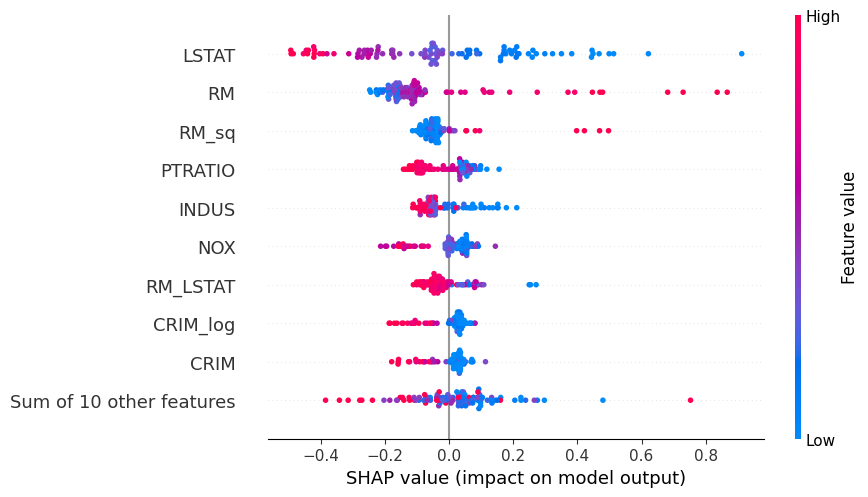

In [62]:
shap.plots.beeswarm(shap_values)

Ce *beeswarm plot* représente la distribution des valeurs SHAP associées aux différentes variables du modèle, permettant d’évaluer leur influence sur les prédictions. L’axe des \( X \) correspond aux valeurs SHAP, indiquant si une variable contribue positivement ou négativement à la sortie du modèle. L’axe des \( Y \) classe les variables par ordre décroissant d’importance, basé sur la moyenne absolue de leurs valeurs SHAP. Chaque point représente une observation individuelle, sa position horizontale indiquant l’effet de la variable sur la prédiction, tandis que sa couleur traduit la valeur de la variable (rouge pour les valeurs élevées, bleu pour les valeurs faibles).  

L’analyse du graphique révèle que **LSTAT** (proportion de population à faible statut socio-économique) est la variable la plus influente, avec une relation clairement monotone : des valeurs élevées (rouge) augmentent fortement la prédiction, tandis que des valeurs faibles (bleu) la réduisent. À l’inverse, **RM** (nombre moyen de pièces par logement) suit une relation opposée, où des valeurs élevées réduisent la prédiction et des valeurs faibles l’augmentent. La dispersion des valeurs SHAP pour ces variables est large, soulignant leur fort impact.  

Certaines variables, comme **NOX** (concentration en oxydes d’azote) et **INDUS** (proportion de terrains industriels), présentent une distribution plus complexe, avec un chevauchement des couleurs, indiquant une relation non strictement monotone avec la prédiction. **PTRATIO** (ratio élèves/enseignants) et **CRIM_log** (logarithme du taux de criminalité) montrent également une influence significative, bien que plus modérée.  

Ce graphique met en évidence la manière dont chaque variable contribue aux décisions du modèle. Il permet non seulement d’identifier les variables clés mais aussi de comprendre la nature de leur relation avec la variable cible, facilitant ainsi l’interprétation et l’explicabilité du modèle.

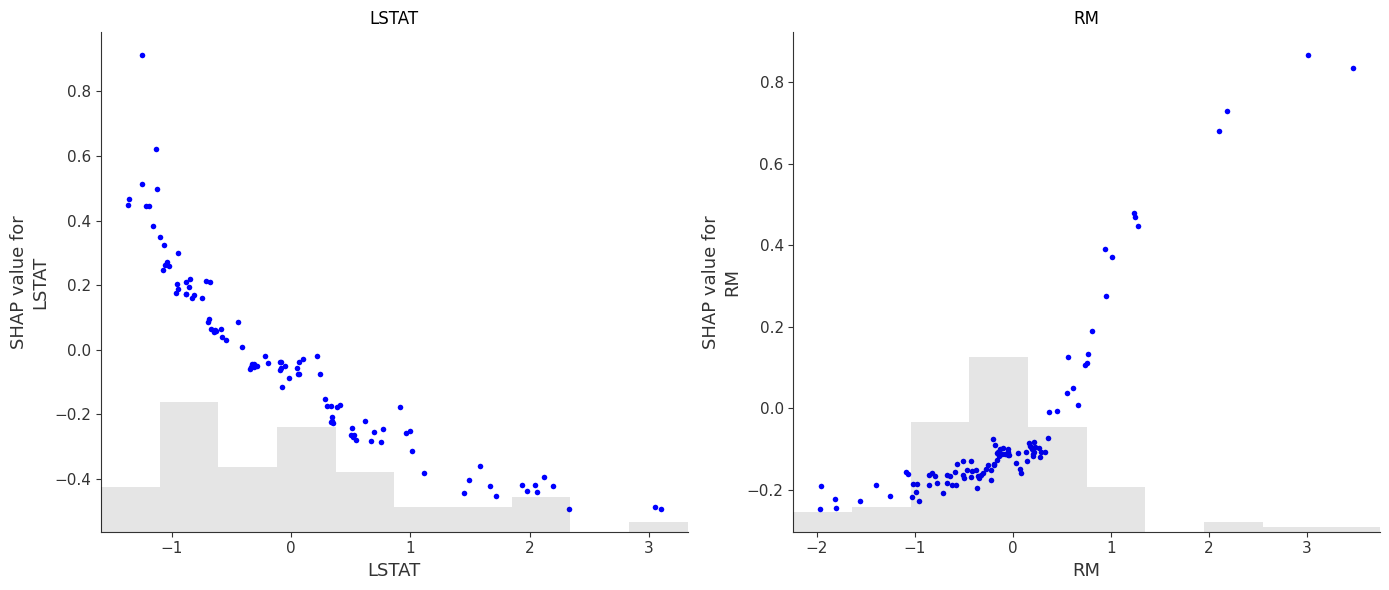

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pot de shap pour la variable 'LSTAT'
shap.plots.scatter(shap_values[:, 'LSTAT'], show=False, ax=axes[0])
axes[0].collections[0].set_facecolor('blue')  
axes[0].set_title('LSTAT')

# Pot de shap pour la variable 'RM'
shap.plots.scatter(shap_values[:, 'RM'], show=False, ax=axes[1])
axes[1].collections[0].set_facecolor('blue') 
axes[1].set_title('RM')

plt.tight_layout()
plt.show()

Les graphiques SHAP présentés illustrent la relation entre les variables explicatives LSTAT et RM et leur impact sur les prédictions du modèle appliqué au Boston Housing Dataset. Ces visualisations de type scatter permettent d'examiner précisément comment chaque variable influence individuellement les prédictions de prix immobiliers.

Pour la variable LSTAT (pourcentage de population de statut économique inférieur), le graphique révèle une relation négative prononcée. Lorsque les valeurs de LSTAT sont faibles (inférieures à 0), les valeurs SHAP correspondantes sont majoritairement positives, atteignant jusqu'à 0,9. À mesure que LSTAT augmente (vers des valeurs supérieures à 1), les valeurs SHAP deviennent de plus en plus négatives, descendant jusqu'à -0,5. Cette tendance décroissante montre clairement que des taux plus élevés de population défavorisée contribuent négativement aux prédictions de prix, confirmant l'effet défavorable de cette variable socioéconomique sur le marché immobilier.

Concernant la variable RM (nombre moyen de pièces par logement), le graphique montre une relation positive distincte. Pour les valeurs faibles de RM (inférieures à -1), les valeurs SHAP sont négatives, autour de -0,2. À mesure que RM augmente, les valeurs SHAP s'élèvent progressivement, avec une hausse particulièrement marquée pour les valeurs de RM supérieures à 1, où les valeurs SHAP atteignent entre 0,7 et 0,9. Cette courbe ascendante indique qu'un nombre plus élevé de pièces par logement contribue significativement à augmenter les prédictions de prix.

Les histogrammes gris en arrière-plan représentent la distribution des valeurs pour chaque variable dans le dataset, permettant de contextualiser la fréquence d'occurrence de chaque niveau de variable et leur influence correspondante.